# Web Scraping & Portfolio Analysis of Fund Data
This application allows the user to define a portfolio of funds by ISIN and presents portfolio stratification in a common user-defined currency.

The script is scraping publicly accessbile fund data from www.fondsprofessionell.at. All information is being converted into the desired reporting currency by its current FX spot-rate (sourced from ECB). Among others, the following data points can be automatically retrieved:

- NAV
- Historical performance
- Top holdings
- Asset allocation
- Sector allocation
- Countries
- Currencies

The user-defined list of funds is jointly analyzed to give a holistic view on the portfolio characteristics. The output is presented in various visualizations at the bottom of the document.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1-LIBRARIES" data-toc-modified-id="1-LIBRARIES-1">1 LIBRARIES</a></span></li><li><span><a href="#2-USER-INPUT" data-toc-modified-id="2-USER-INPUT-2">2 USER INPUT</a></span></li><li><span><a href="#3-FUNCTIONS" data-toc-modified-id="3-FUNCTIONS-3">3 FUNCTIONS</a></span><ul class="toc-item"><li><span><a href="#3.1-Error-Handling" data-toc-modified-id="3.1-Error-Handling-3.1">3.1 Error Handling</a></span></li><li><span><a href="#3.2-Scraping" data-toc-modified-id="3.2-Scraping-3.2">3.2 Scraping</a></span></li><li><span><a href="#3.3-Tabularizing" data-toc-modified-id="3.3-Tabularizing-3.3">3.3 Tabularizing</a></span></li><li><span><a href="#3.4-FX" data-toc-modified-id="3.4-FX-3.4">3.4 FX</a></span></li><li><span><a href="#3.5-Visualization" data-toc-modified-id="3.5-Visualization-3.5">3.5 Visualization</a></span></li></ul></li><li><span><a href="#4-RUN" data-toc-modified-id="4-RUN-4">4 RUN</a></span><ul class="toc-item"><li><span><a href="#4.1-FX-Table" data-toc-modified-id="4.1-FX-Table-4.1">4.1 FX Table</a></span></li><li><span><a href="#4.2-Funds" data-toc-modified-id="4.2-Funds-4.2">4.2 Funds</a></span></li></ul></li><li><span><a href="#5-PORTFOLIO-ANALYSIS" data-toc-modified-id="5-PORTFOLIO-ANALYSIS-5">5 PORTFOLIO ANALYSIS</a></span><ul class="toc-item"><li><span><a href="#5.1-Net-Asset-Value" data-toc-modified-id="5.1-Net-Asset-Value-5.1">5.1 Net Asset Value</a></span></li><li><span><a href="#5.2-Performance" data-toc-modified-id="5.2-Performance-5.2">5.2 Performance</a></span></li><li><span><a href="#5.3-Asset-Class" data-toc-modified-id="5.3-Asset-Class-5.3">5.3 Asset Class</a></span></li><li><span><a href="#5.4-Holdings" data-toc-modified-id="5.4-Holdings-5.4">5.4 Holdings</a></span></li><li><span><a href="#5.5-Currency" data-toc-modified-id="5.5-Currency-5.5">5.5 Currency</a></span></li><li><span><a href="#5.6-Sector" data-toc-modified-id="5.6-Sector-5.6">5.6 Sector</a></span></li><li><span><a href="#5.7-Country" data-toc-modified-id="5.7-Country-5.7">5.7 Country</a></span></li></ul></li></ul></div>

<div class="alert alert-block alert-danger">
<b>Disclaimer:</b>
This script shall not be used for any commercial purposes.
</div>

### 1 LIBRARIES
***

In [1]:
# Webscraping
from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from webdriver_manager.chrome import ChromeDriverManager

# Data preparation
import datetime
import numpy as np
import pandas as pd
from pandas.tseries.offsets import MonthEnd

# Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mpl


# Settings
pd.options.display.float_format = '{:,.2f}'.format
%config InlineBackend.figure_format ="retina"

### 2 USER INPUT
***

In [2]:
# Constants specifying the source from where data is being scraped
PAGE_FUNDS = "https://www.fondsprofessionell.at"
PAGE_FX = "https://www.ecb.europa.eu/stats/policy_and_exchange_rates/euro_reference_exchange_rates/html/index.en.html"

In [3]:
# Enter ISIN and number of purchased fund certificates
custody = {"IE0007471695":100,
           "IE00BYXVW230":2000,
           "DE0006289309":5000,
           "LU1548497772":100,
           "IE00B0M62Q58":1000,
           "FR0010429068":2000,
           "LU0131212812":500,
           "IE0005042456":5000}

In [4]:
#Enter currency code in which portfolio shall be calculated and visualized in
rep_currency = "USD"

In [5]:
# Enter the base date from which the performance shall be shown onwards
base_date = "2019-01-01"

### 3 FUNCTIONS
***

#### 3.1 Error Handling

In [6]:
def check_element(css):
    """
    This function checks if an element is existing, is enabled and displayed.
    Required parameters: css selector of element under inspection
    """
    
    try:
        element = driver.find_element_by_css_selector(css)
        if (element.is_enabled()) and (element.is_displayed()):
            return True
        else:
            return False
    
    except NoSuchElementException:
        return False

#### 3.2 Scraping

In [7]:
def scrape_url(isin):
    """
    This function scrapes the fund specific part of its URL.
    Required parameters: ISIN of the fund
    """
    
    # 1. CSS selectors
    css_header        = "#shadow > header > div:nth-child(1) > div:nth-child(2) > div.col-xs-7.head-search > "
    css_search_box    = css_header + "div.search-fond.pull-right > form > div.input-group > input.form-control"
    css_search_button = css_header + "div.search-fond.pull-right > form > div.input-group > button > span"
    css_fund_link     = "#fundSearchView > table > tbody > tr:nth-child(2) > td:nth-child(1) > a"
    
    
    # 2. Edit search box and fill in isin
    search_box = driver.find_element_by_css_selector(css_search_box)
    search_box.clear()
    search_box.send_keys(isin)
    
    
    # 3. Click search button
    driver.find_element_by_css_selector(css_search_button).click()


    # 4. Extract url
    if check_element(css_fund_link) == True:
        ele = driver.find_element_by_css_selector(css_fund_link)
        ele = ele.get_attribute('href')

        # 4.1 Remove common part of url
        if PAGE_FUNDS in ele: ele = ele.replace(PAGE_FUNDS,"")
        return ele
    
    else:
        return None

In [8]:
def scrape_object(obj_type):
    """
    This function scrapes the tables containing all fund details.
    Parameters required: Type of object to be scraped (either "Table" or "Series" or "FX") 
    """
    
    # 1. Get size of object
    if obj_type == "Fund Series":
        css_base = "#BiggestPositions > table > tbody > tr"
        rows = len(driver.find_elements_by_css_selector(css_base))
        cols = 3
        
        if rows == 0: return None
        
    elif obj_type == "Fund Table":
        css_main = "#shadow > main > div:nth-child(2) > div > div.col-xs-8.content-main > "
        css_base = css_main+"div:nth-child(2) > div.clear > div > table:nth-child(7) > tbody > tr"
        rows = len(driver.find_elements_by_css_selector(css_base))
        cols = int(len(driver.find_elements_by_css_selector(css_base+" > td"))/rows)
        
    elif obj_type == "FX":
        css_base = "#ecb-content-col > main > div.forextable > table > tbody > tr"
        rows = len(driver.find_elements_by_css_selector(css_base))
        cols = int(len(driver.find_elements_by_css_selector(css_base+" > td"))/rows)
        
    else:
        print ("Parameter obj_type must be either 'Fund Series' or 'Fund Table' or 'FX'.")
        return None

    
    # 2. Get list of css selectors
    css_list = list()
    for i in range(1, rows+1):
        for j in range(1, cols+1):
            css = css_base+":nth-child("+str(i)+") > td:nth-child("+str(j)+")"
            css_list.append(css)


    # 3. Get elements from iterating through css selectors
    df_sub, df_main = list(), list()
    
    for i,j in enumerate (css_list,1):
        element = driver.find_element_by_css_selector(j)
        df_sub.append(element.text)
        if (i%cols == 0) and (i>0):
            df_main.append(df_sub)
            df_sub = list()
    
    
    # 4. Transform to data frame or series
    df = pd.DataFrame(data = df_main)
    if obj_type == "Fund Series":
        df = df.drop(0, axis=1)
        
    elif obj_type == "Fund Table":
        df.columns = df.iloc[0]
        df = df[1:]
        df = df.set_index([""])
        df = df.unstack()
        
    elif obj_type == "FX":
        df.columns = ["Code","Name","Rate","Blank"]
        df.index = df["Code"]
        df.index.Name = None
        df = df[["Name","Rate"]]
        
    else: return None
    
    return df

In [9]:
def to_float(df, col):
    """
    This function converts the column of a dataframe into numeric format.
    Required parameters:
     - Dataframe
     - Name of column to be convered
    """
    
    df[col] = df[col].str.replace(",",".")
    df[col] = df[col].apply(lambda x: x[1:-1] if x[0] == "+" else x[:-1])
    df[col] = pd.to_numeric(df[col])
    return df

#### 3.3 Tabularizing

In [10]:
def tab_performance(isin, nav):
    """
    This function combines all historical performance tables to a dataframe.
    Required parameters:
     - ISIN of fund
     - NAV of fund (to convert relative to absolute exposure)
    """
    
    # 1. Scrape initial performance table
    df_first = scrape_object("Fund Table")


    # 2. Scrape further performance tables
    df_cont = list()
    
    for i in range(3,10):
        if check_element("#perfPages > li:nth-child("+str(i)+") > a") == True:
            driver.find_element_by_css_selector("#perfPages > li:nth-child("+str(i)+") > a").click()
            df_cont.append(scrape_object("Fund Table"))

            
    # 3. Create joint data frame
    df = df_first.append(df_cont)
    df = pd.DataFrame(df)
    df["ISIN"] = isin
    
    
    # 4. Extract date columns from index
    df["Year"]  = df.index.get_level_values(0)
    df["Month"] = df.index.get_level_values(1)
    df["Month"] = df["Month"].apply(lambda x: x[0] if type(x) == tuple else x)
    
    
    # 5. Filter and rename columns
    df = df[df["Month"]!="Gesamt"]
    df = df.rename(columns={0:"PCT"})
    df = df.reset_index(drop = True)
    
    
    # 6. Extract datetime
    df["Month"] = df.index%12+1
    df["Day"] = 1
    df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]], format='%Y%m%d', errors='ignore') + MonthEnd(1)
    df = df.sort_values(by="Date", ascending = True)
    
    
    # 7. Percentage columns
    df = to_float(df, "PCT")
    df = df.fillna(0)
    df["PCT CUM"] = df["PCT"].cumsum()
    df = df[["ISIN","Date","PCT","PCT CUM"]]
    return df

In [11]:
def tab_details(isin, nav, idx, name):
    """
    This function converts the scraped details of the fund to a data frame.
    Required parameters:
     - ISIN of the fund
     - NAV of the fund (to convert relative to absolute exposure)
     - Index referencing the type of information (e.g. 2= Holdings, 3=Currency)
     - Name that shall be assigned to the column of the output data frame
    """
    
    # 1. Click link to respective element of interest
    driver.find_element_by_css_selector("#chart > ul > li:nth-child("+str(idx)+") > a").click()

    
    # 2. Transform scraped elements to data frame
    df = scrape_object("Fund Series")
    if df is not None: 
        df["ISIN"] = isin
        df.columns = [name, "PCT", "ISIN"]
        df = to_float(df,"PCT") 
        
        # 2.1 Add row with residual value (in case values do not add up to 100%)
        df.loc[df.shape[0]] = ["Other"] + [100-sum(df["PCT"])] + [isin]
        
        # 2.2 Calculate absolute exposure
        df["EUR"] = df["PCT"]/100*custody[isin]*nav
        df = df[["ISIN", name, "PCT", "EUR"]]

    return df

In [12]:
def tab_pivot(df, col):
    """
    This function pivots the flat file, by putting each fund into a separate column.
    Required parameters:
     - Data frame of interest
     - Name of the column that shall be kept as index
    """
    
    # 1. Pivot the table
    df = df.pivot_table(columns = ["ISIN"], values = ["EUR"], index = [col], aggfunc=np.mean)
    df = df.fillna(0)
    
    
    # 2. Format the table
    df.index.name = None
    df.columns = df.columns.get_level_values(1)
    
    
    # 3. Create column for portfolio total
    df["TOTAL"] = df.sum(axis = 1)
    df = df.sort_values(by = "TOTAL", ascending = False)
    
    return df

#### 3.4 FX

In [13]:
def get_fx_rate(currency):
    """
    This function checks if a currency code exists in the fx table from ECB.
    Required parameters: Currency code under inspection
    """
    
    if currency not in fx.index:
        if currency == "EUR":
            rate = 1
        else:
            print (f'The FX rate for {nav_currency} is not availble')
            
    else:
        rate = fx[fx.index == currency]["Rate"][0]
        rate = float(rate)
        
    return rate

In [14]:
def get_fx_nav(rep_currency, nav_currency, fx_rep, fx_nav, nav_orig):
    """
    This function converts the NAV from its quoted currency into the user-defined reporting currency.
    Required parameters:
     - rep_currency: Reporting currency
     - nav_currency: Quoted currency of the fund
    """
    
    if rep_currency != nav_currency:
        if rep_currency == "EUR":
            nav_conv = nav_orig/fx_nav
            
        elif nav_currency == "EUR":
            nav_conv = nav_orig*fx_rep
            
        else: 
            nav_conv = nav_orig/fx_nav*fx_rep
    
    else:
        nav_conv = nav_orig
        
    return nav_conv

#### 3.5 Visualization

In [15]:
def viz_bar(df, title):
    """
    This function generates a stanardized output visualization in the form of a stacked bar chart.
    Required parameters: Data frame of interest
    """
    
    fig = plt.figure(1, figsize=(15,7))

    for i in df.columns[:-1]:
        bottom_idx = df.columns.get_loc(i)
        bottom = np.sum(df.iloc[:,:bottom_idx], axis = 1)

        x = df.index
        y = df[i]
        plt.bar(x, y, color = color_dict[i], bottom = bottom, label = i)

    plt.legend(title = "Funds")
    plt.title(title)
    plt.ylabel(rep_currency)
    plt.xticks(rotation=90)
    plt.show()

In [16]:
def viz_colors():
    """
    This function generates a dictionary that assigns a specific color from a color spectrum to each fund.
    It enables consistent coloring across visualizations.
    """
    
    c_scale = cm.rainbow(np.linspace(0,1,len(custody)))
    c_dict = {}

    for i,c in zip(list(custody.keys()),c_scale):
        c_dict[i] = c
        
    return c_dict

### 4 RUN
***

In [17]:
# Start webdriver (update if necessary)
driver = webdriver.Chrome(ChromeDriverManager().install())
driver.maximize_window()

[WDM] - Current google-chrome version is 87.0.4280
[WDM] - Get LATEST driver version for 87.0.4280
[WDM] - Driver [C:\Users\bernh\.wdm\drivers\chromedriver\win32\87.0.4280.88\chromedriver.exe] found in cache


#### 4.1 FX Table

In [18]:
# Driver opens ECB & accept cookies
css_cookie = "#cookieConsent > div.initial > div > a.check.linkButton.linkButtonLarge.floatLeft.highlight-medium"

driver.get(PAGE_FX)
driver.find_element_by_css_selector(css_cookie).click()

# Scrape fx table
fx = scrape_object("FX")

In [19]:
fx

,Name,Rate
Code,,
USD,US dollar,1.2271
JPY,Japanese yen,126.49
BGN,Bulgarian lev,1.9558
CZK,Czech koruna,26.242
DKK,Danish krone,7.4409
GBP,Pound sterling,0.89903
HUF,Hungarian forint,363.89
PLN,Polish zloty,4.5597
RON,Romanian leu,4.8683


#### 4.2 Funds

In [20]:
# Driver opens fondsprofessionell
driver.get(PAGE_FUNDS)
driver.find_element_by_css_selector("#cookieauthCloser").click()

# Negate mobile page view 
css_mobile = "#mobileConfirm > form > input[type=submit]:nth-child(2)"
if check_element(css_mobile) == True:
    driver.find_element_by_css_selector(css_mobile).click()

In [21]:
# Initialize objects
nav = pd.DataFrame(columns = ["ISIN", 
                              "Fund Name", 
                              "Price Date",
                              "Price",
                              "Quote Currency", 
                              "Amount", 
                              "NAV in "+rep_currency])

performance   = pd.DataFrame()
details       = [pd.DataFrame() for i in range(5)]
details_names = ["Issuer", "Currency", "Sector", "Country", "Asset Class"]

In [22]:
# Iterate through funds
for count, isin in enumerate(custody.keys()):
    
    # 1. Navigate to respective fund
    driver.implicitly_wait(3)
    if scrape_url(isin) == None:
        print (f'{isin} has not been found')
        continue
    else:
        driver.get(PAGE_FUNDS+scrape_url(isin))


    # 2. Specify css selectors
    css_base      = "#shadow > main > div:nth-child(2) > div > div.col-xs-8.content-main > div:nth-child(2) > "
    css_fund_name = css_base+"h1"
    css_nav_orig  = css_base+"p > span:nth-child(10)"
    css_nav_date  = css_base+"p > span:nth-child(11)"
    css_details   = "#iv-fonds > nav > a:nth-child(5)"
  

    # 3. Get basic fund data
    fund_name = driver.find_element_by_css_selector(css_fund_name).text

    nav_orig = driver.find_element_by_css_selector(css_nav_orig).text
    nav_orig, nav_currency = nav_orig.split(" ")
    
    nav_orig = nav_orig.replace(".","")
    nav_orig = float(nav_orig.replace(",","."))
    
    nav_date = driver.find_element_by_css_selector(css_nav_date).text
    nav_date = datetime.datetime.strptime(nav_date, '%d.%m.%Y').date()
    
    
    # 4. Convert NAV into reporting currency
    fx_nav = get_fx_rate(nav_currency)
    fx_rep = get_fx_rate(rep_currency)
    nav_conv = get_fx_nav(rep_currency = rep_currency,
                          nav_currency = nav_currency,
                          fx_rep = fx_rep,
                          fx_nav = fx_nav,
                          nav_orig = nav_orig)

    
    # 5. Create NAV table
    nav.loc[count] = [isin]+[fund_name]+[nav_date]+[nav_orig]+[nav_currency]+[custody[isin]]+[nav_conv*custody[isin]]

    
    # 6. Get performance data
    performance_temp = tab_performance(isin, nav_orig)
    performance      = pd.concat([performance, performance_temp], ignore_index = True)

    
    # 7. Navigate to details
    driver.find_element_by_css_selector(css_details).click()

    
    # 8. Get details data
    for i,j in zip(range(5), details_names):
        details_temp = tab_details(isin, nav_orig, i+1, j)
        details[i]   = pd.concat([details[i], details_temp], ignore_index = True)

In [23]:
# Close webdriver
driver.quit()

### 5 PORTFOLIO ANALYSIS
***

#### 5.1 Net Asset Value

In [24]:
# Depicting overall information about the portfolio of funds
nav_total = sum(nav["NAV in "+rep_currency])
print(f' The portfolio is valued at {round(nav_total,2):,} {rep_currency}')

nav

 The portfolio is valued at 353,916.04 USD


,ISIN,Fund Name,Price Date,Price,Quote Currency,Amount,NAV in USD
0,IE0007471695,Vanguard U.S.Government B.Ind.F.Inv.USD,2020-12-30,208.39,USD,100,"20,839.00"
1,IE00BYXVW230,PIMCO GIS Gl.Bd.ESG F.E USD,2020-12-30,11.07,USD,2000,"22,140.00"
2,DE0006289309,iShares EURO STOXX Banks 30-15 U.E.(DE),2020-12-30,7.20,EUR,5000,"44,175.60"
3,LU1548497772,Allianz Gl.Artificial Intell.AT EUR H2,2020-12-30,261.41,EUR,100,"32,077.62"
4,IE00B0M62Q58,iShares MSCI W.U.E.USD D,2020-12-30,57.11,USD,1000,"57,110.00"
5,FR0010429068,Lyxor MSCI Emerging Markets U.E.Acc EUR,2020-12-30,11.97,EUR,2000,"29,376.77"
6,LU0131212812,BNPP Euro Corporate Bd.P EUR,2020-12-29,170.13,EUR,500,"104,383.26"
7,IE0005042456,iShares Core FTSE 100 U.E.GBP D,2020-12-30,6.42,GBP,5000,"43,813.79"


In [25]:
# Ensuring consistent coloring per each fund
color_dict = viz_colors()

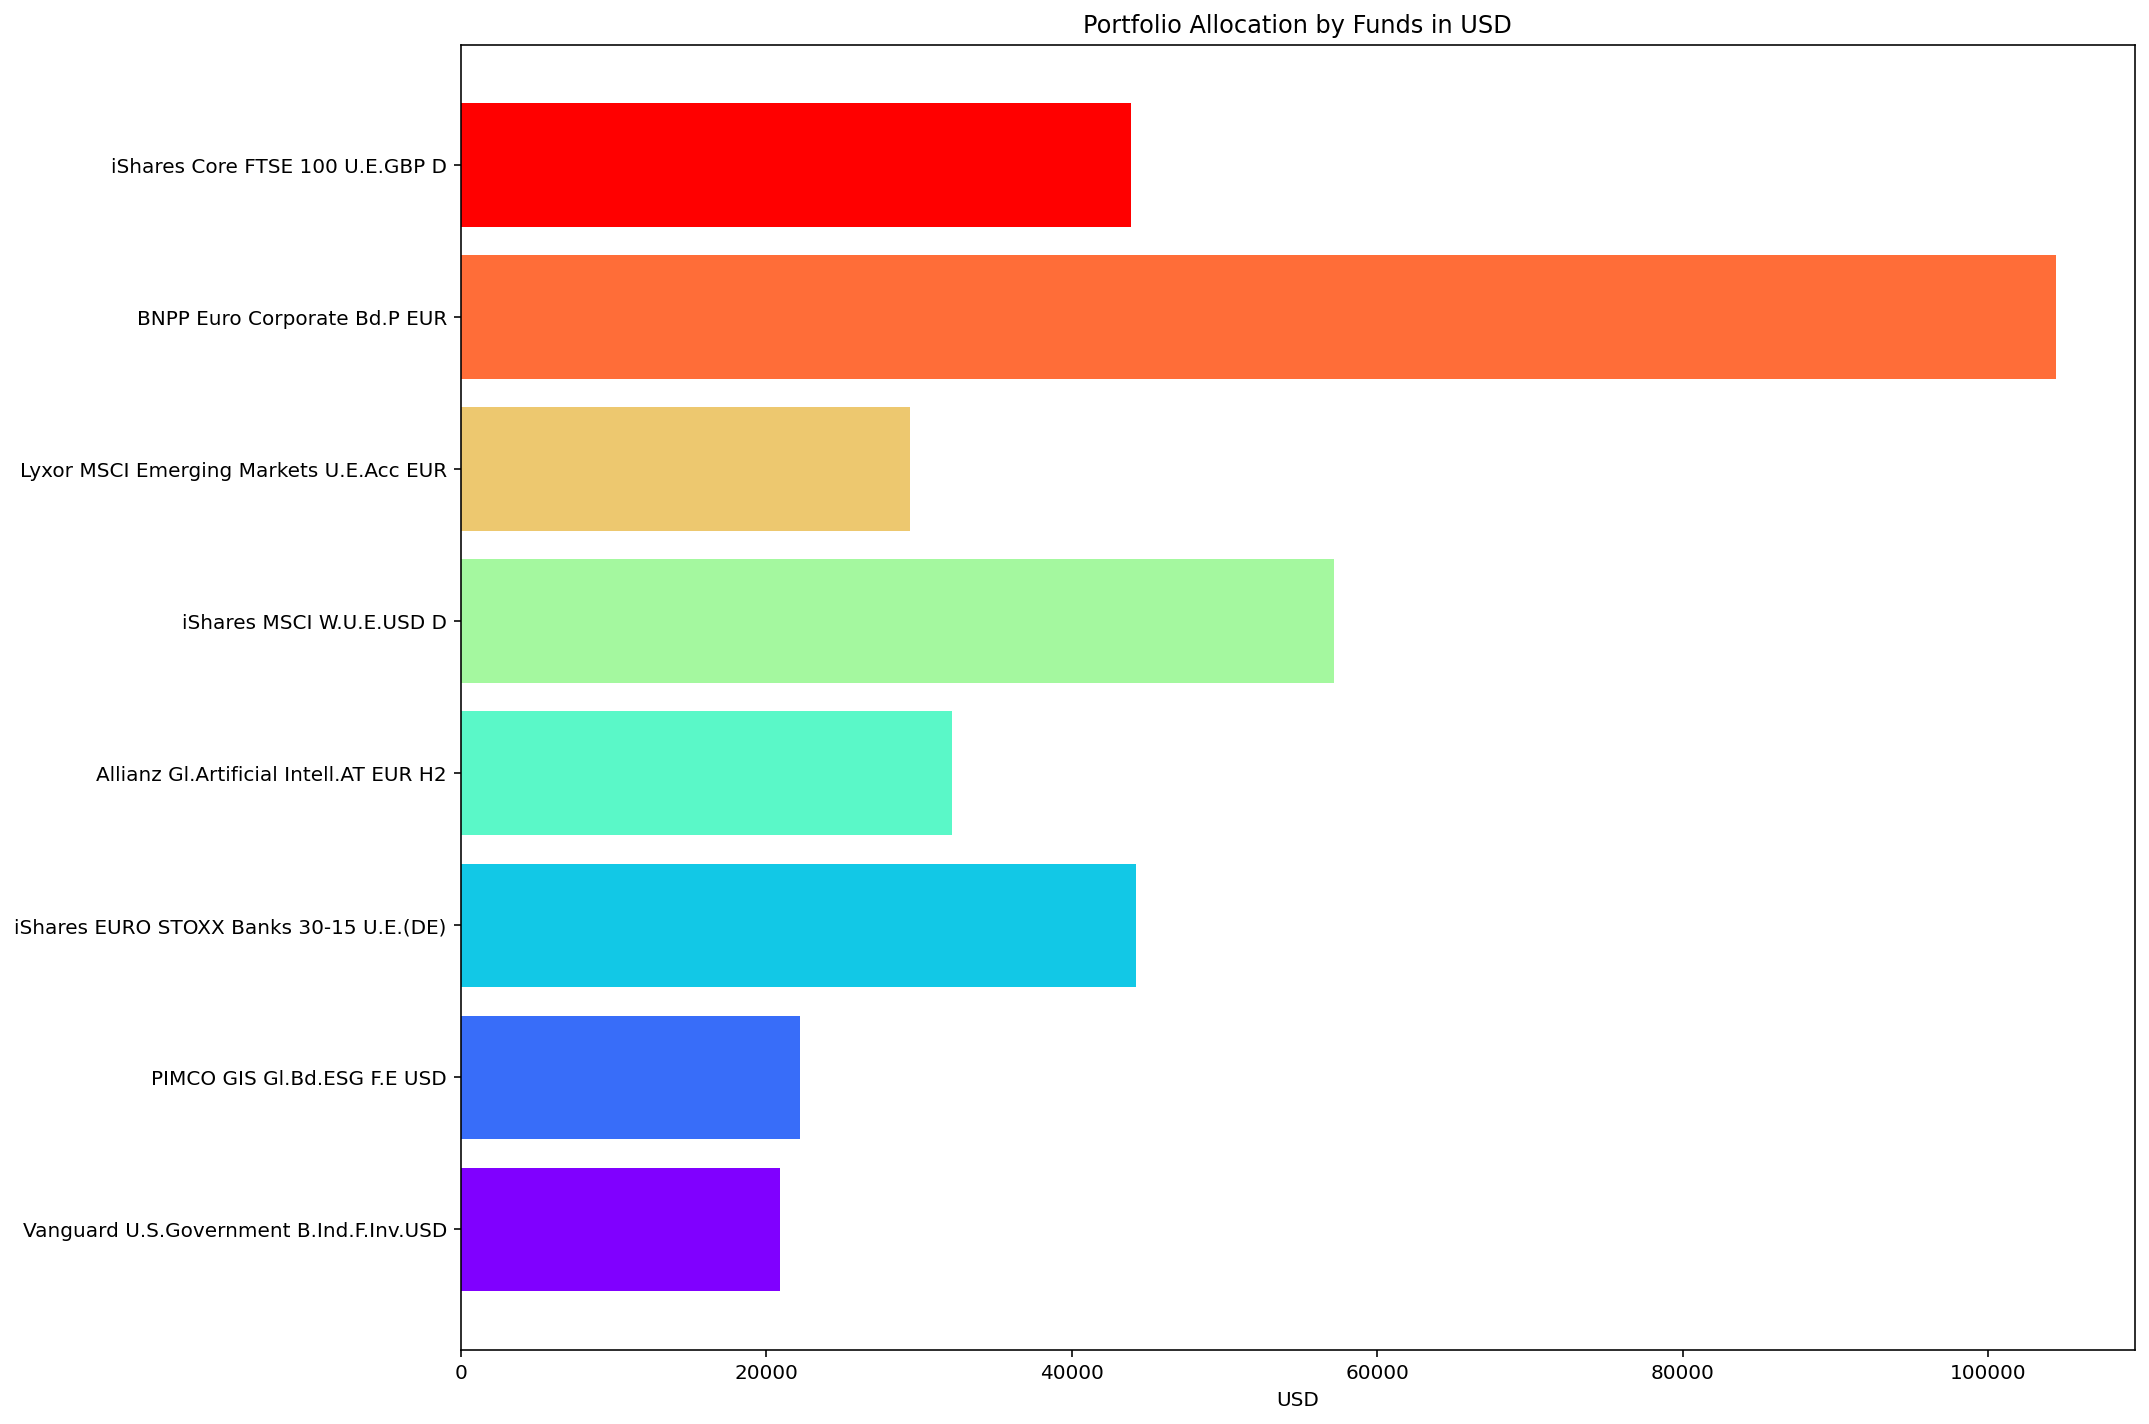

In [26]:
# Depicting the overall allocation to funds in reporting currency
fig = plt.figure(figsize = [15,1.5*len(custody)])

x, y, c = nav["Fund Name"], nav["NAV in "+rep_currency], nav["ISIN"]
chart = plt.barh(x, y)

for i,j in enumerate (c):
    chart[i].set_color(color_dict[j])

plt.title(f'Portfolio Allocation by Funds in {rep_currency}')
plt.xlabel(rep_currency)
plt.show()

#### 5.2 Performance

In [27]:
# Depicting the cumulative performance of each fund since inception
performance = performance.pivot_table(columns = ["ISIN"], 
                                      values = ["PCT CUM"], 
                                      index = ["Date"], 
                                      aggfunc=np.mean)

performance.index.name = None
performance.columns = performance.columns.get_level_values(1)
performance.tail()

ISIN,DE0006289309,FR0010429068,IE0005042456,IE0007471695,IE00B0M62Q58,IE00BYXVW230,LU0131212812,LU1548497772
2020-08-31,-27.51,68.49,60.49,77.32,118.37,11.16,70.55,80.83
2020-09-30,-39.47,68.78,58.93,77.54,114.84,11.54,70.88,78.56
2020-10-31,-41.55,71.46,54.18,76.55,111.75,11.72,71.63,83.04
2020-11-30,-3.40,77.78,66.83,76.97,124.52,12.73,73.20,103.35
2020-12-31,-2.98,81.93,71.07,76.70,128.32,13.09,73.55,107.83


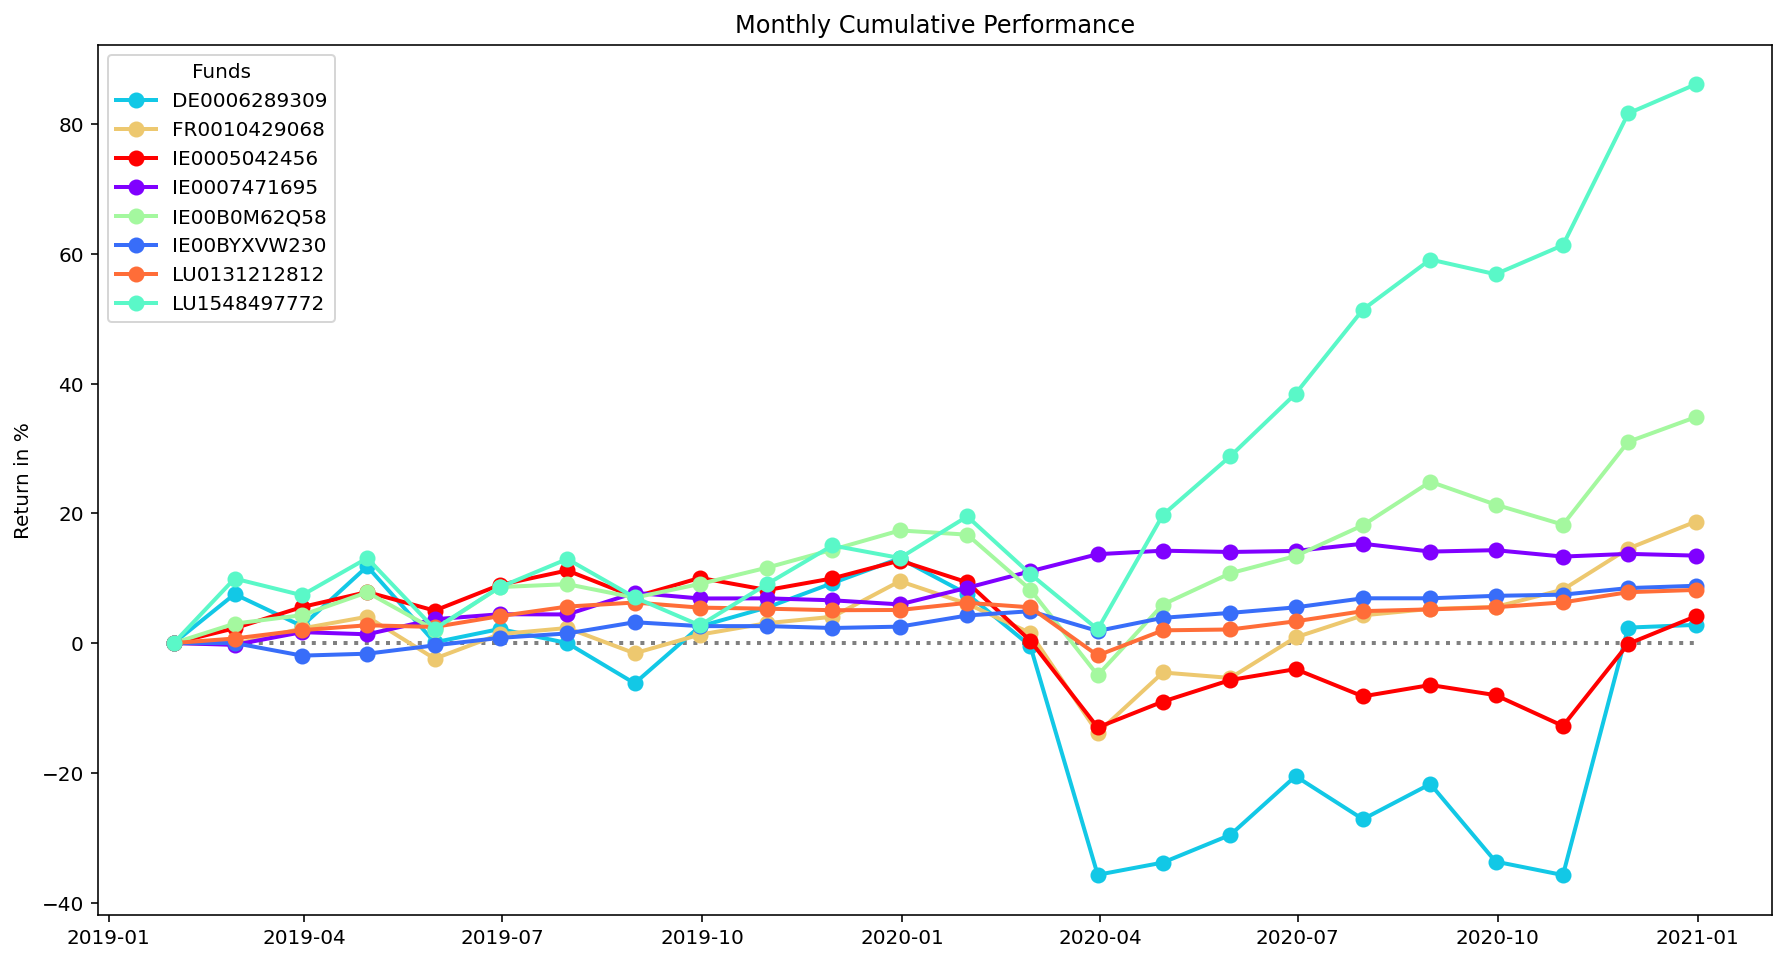

In [28]:
# Filter the performance data frame
selection = performance[performance.index >= base_date]


# Initialize figure
fig = plt.figure(figsize = [15,8])

# Create zero-line
plt.hlines(0, selection.index[0], 
              selection.index[-1], 
              colors="grey", 
              linestyles="dotted", 
              linewidth = 2)

# Create each line per fund
for i in performance.columns:
    series = selection[i] - selection[i][0]
    plt.plot(series,
             c = color_dict[i], 
             label = i, 
             linewidth = 2,
             marker ="o",
             markersize = 7)

# Chart labels
plt.title ("Monthly Cumulative Performance")
plt.ylabel ("Return in %")
plt.legend(title = "Funds")
plt.show()

#### 5.3 Asset Class

In [29]:
assetclass = tab_pivot(details[4], "Asset Class")
assetclass

ISIN,DE0006289309,FR0010429068,IE0005042456,IE0007471695,IE00B0M62Q58,IE00BYXVW230,LU0131212812,LU1548497772,TOTAL
Aktien,"35,798.40","23,940.00","31,640.97",0.00,"56,915.83",0.00,0.00,"24,598.68","172,893.88"
Anleihen,0.00,0.00,0.00,"18,555.05",0.00,"19,197.59","82,691.69",18.30,"120,462.62"
Other,0.00,0.00,6.42,"2,104.74",0.00,"2,847.20",8.51,0.00,"4,966.87"
Fonds,0.00,0.00,452.61,0.00,194.17,95.20,"1,982.01",0.00,"2,724.00"
Barmittel,201.60,0.00,0.00,0.00,0.00,0.00,0.00,"1,432.53","1,634.13"
Sonstige Vermögenswerte,0.00,0.00,0.00,0.00,0.00,0.00,382.79,0.00,382.79
Barmittel und sonstiges Vermögen,0.00,0.00,0.00,179.22,0.00,0.00,0.00,0.00,179.22
Derivate,0.00,0.00,0.00,0.00,0.00,0.00,0.00,91.49,91.49


#### 5.4 Holdings

In [30]:
holdings = tab_pivot(details[0], "Issuer")
holdings.head()

ISIN,DE0006289309,FR0010429068,IE0005042456,IE0007471695,IE00B0M62Q58,IE00BYXVW230,LU0131212812,LU1548497772,TOTAL
Other,"5,914.80","16,513.81","18,065.88","15,741.78","47,258.53","11,517.23","76,371.36","16,011.36","207,394.75"
BNP Paribas SA,"5,659.20",0.00,0.00,0.00,0.00,0.00,0.00,0.00,"5,659.20"
Banco Santander SA,"4,597.20",0.00,0.00,0.00,0.00,0.00,0.00,0.00,"4,597.20"
Intesa Sanpaolo SpA,"3,981.60",0.00,0.00,0.00,0.00,0.00,0.00,0.00,"3,981.60"
ING Groep NV,"3,646.80",0.00,0.00,0.00,0.00,0.00,0.00,0.00,"3,646.80"


#### 5.5 Currency

In [31]:
currency = tab_pivot(details[1], "Currency")
currency.head()

ISIN,DE0006289309,FR0010429068,IE0005042456,IE0007471695,IE00B0M62Q58,IE00BYXVW230,LU0131212812,LU1548497772,TOTAL
Euro,"35,798.40",780.44,"1,457.34",0.00,"6,293.52","2,988.90","82,632.14",28.76,"129,979.50"
US-Dollar,0.00,"3,236.69",0.00,"20,778.57","37,161.48","13,990.27",0.00,"24,308.52","99,475.51"
Britisches Pfund,0.00,35.91,"30,186.84",0.00,"2,404.33","1,268.62",0.00,0.00,"33,895.70"
Japanischer Yen,0.00,0.00,0.00,0.00,"4,437.45","1,445.74",0.00,190.83,"6,074.02"
Hongkong Dollar,0.00,"4,867.00",0.00,0.00,525.41,0.00,0.00,0.00,"5,392.41"


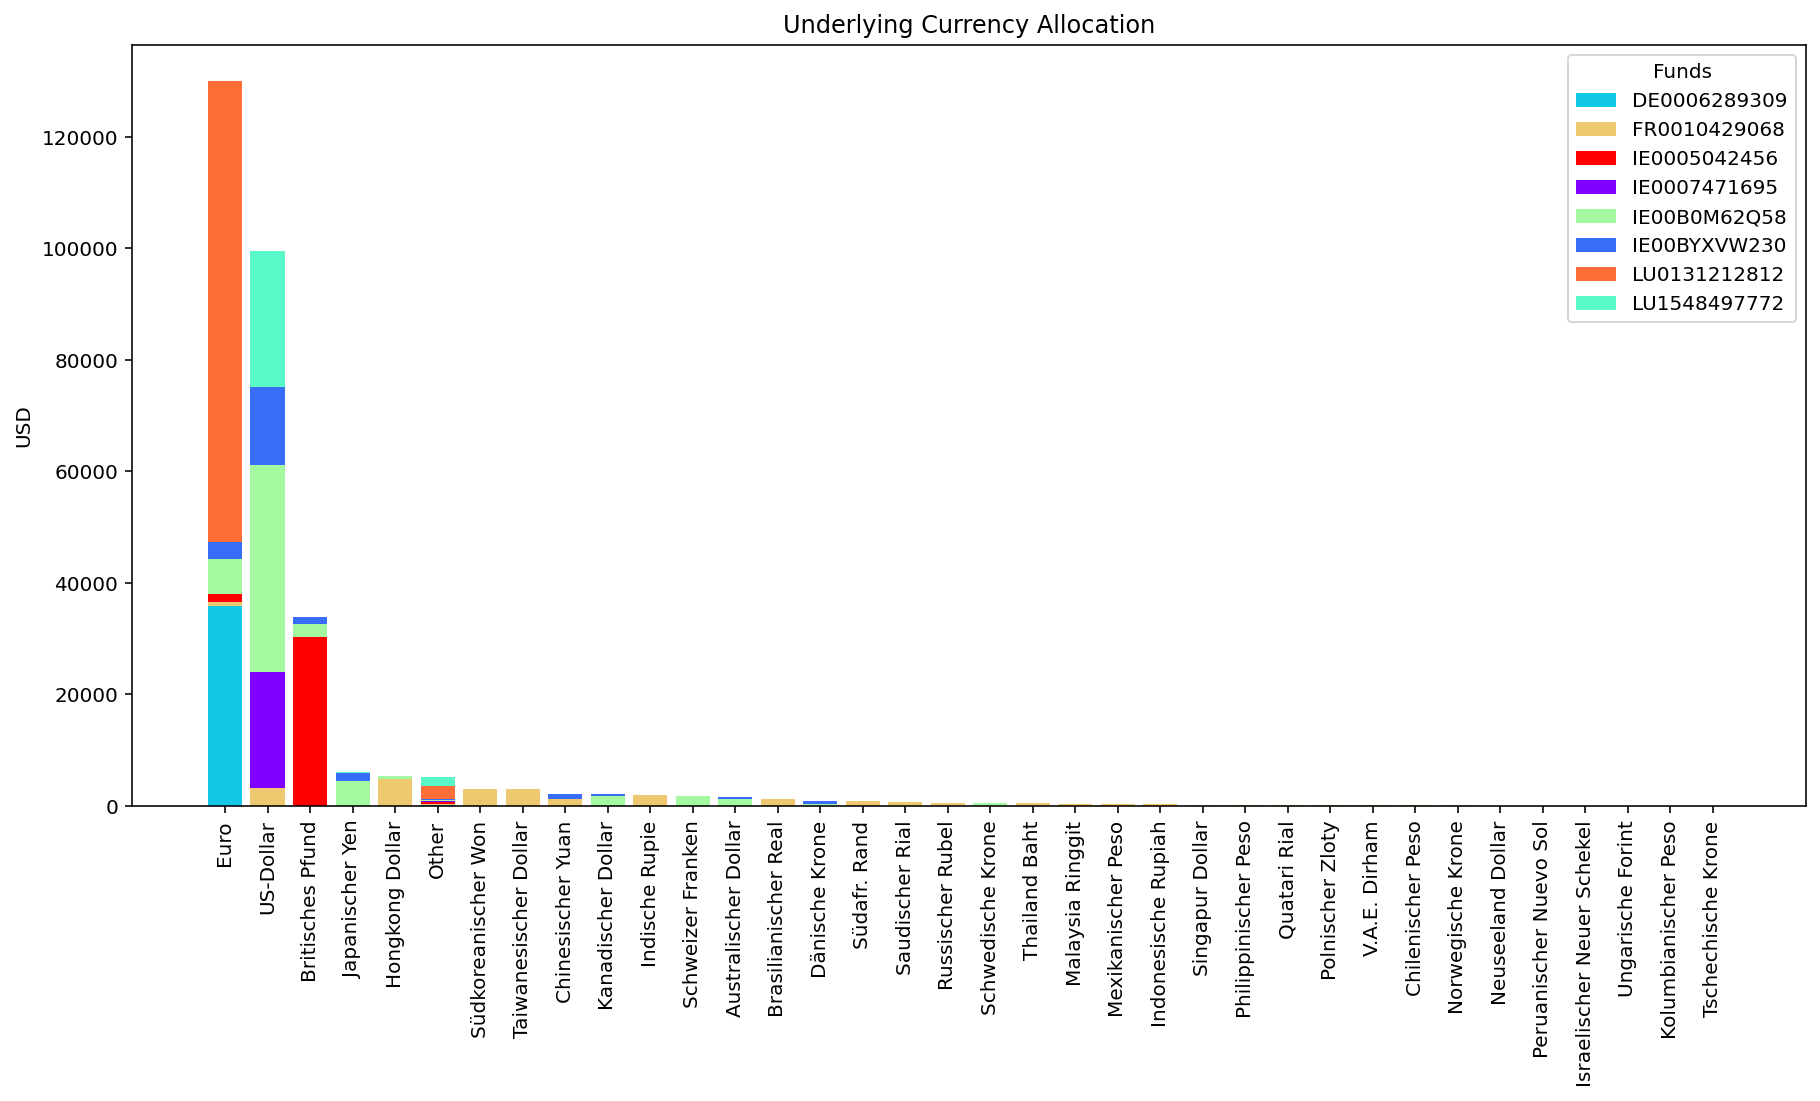

In [32]:
viz_bar(df = currency, title = "Underlying Currency Allocation")

#### 5.6 Sector

In [33]:
sector = tab_pivot(details[2], "Sector")
sector

ISIN,DE0006289309,FR0010429068,IE0005042456,IE00B0M62Q58,LU1548497772,TOTAL
Bank,"35,614.80",0.00,0.00,0.00,0.00,"35,614.80"
IT/Telekommunikation,0.00,"10,208.02","1,823.28","18,109.58",0.00,"30,140.88"
Konsumgüter,0.00,"2,470.61","10,978.20","8,623.61",0.00,"22,072.42"
Finanzen,0.00,"4,294.84","6,079.74","8,652.16",447.01,"19,473.75"
Gesundheitswesen,0.00,890.57,"3,582.36","7,184.44",235.27,"11,892.64"
Informationstechnologie,0.00,0.00,0.00,0.00,"11,603.99","11,603.99"
Industrie,0.00,"1,908.02","1,139.55","6,282.10","1,299.21","10,628.88"
Energie,0.00,"1,742.83","3,652.98","3,398.05",0.00,"8,793.86"
Telekomdienste,0.00,0.00,0.00,0.00,"7,110.35","7,110.35"
Rohstoffe,0.00,"1,522.58","3,450.75","2,135.91",0.00,"7,109.25"


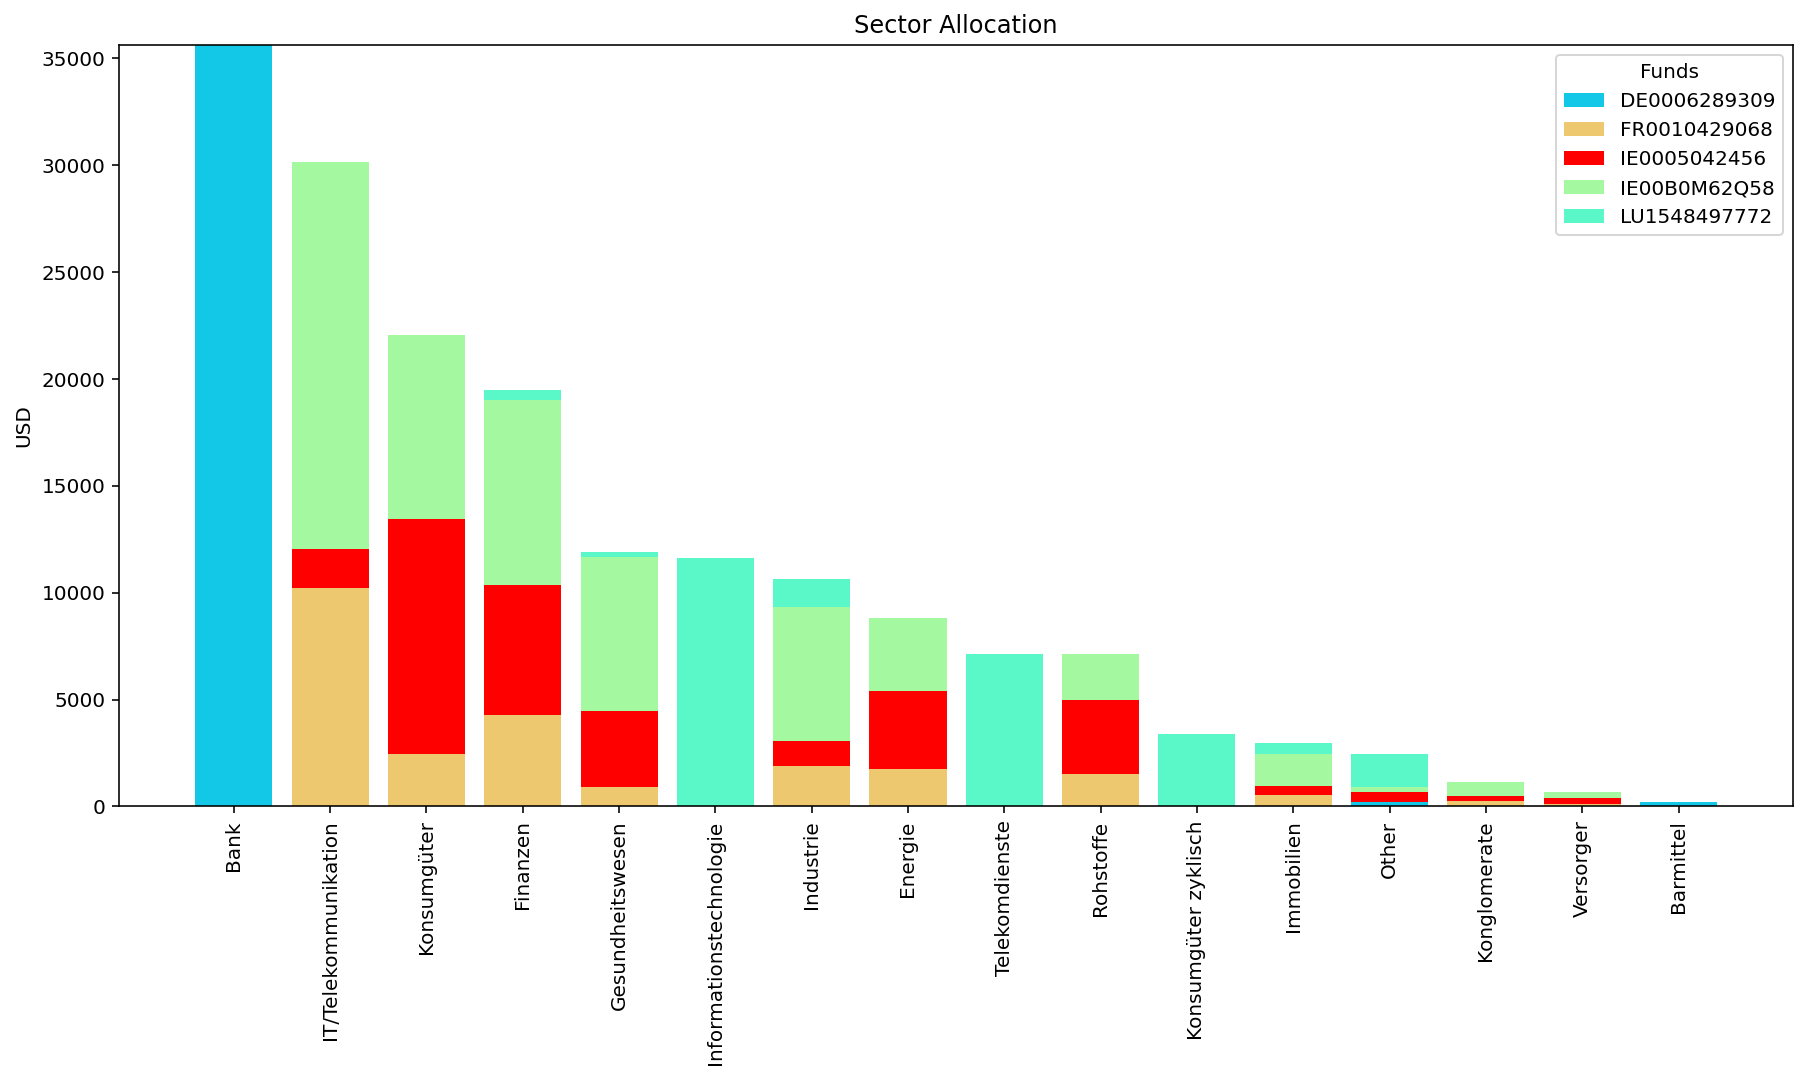

In [34]:
viz_bar(df = sector, title ="Sector Allocation")

#### 5.7 Country

In [35]:
country = tab_pivot(details[3], "Country")
country.head()

ISIN,DE0006289309,FR0010429068,IE0005042456,IE0007471695,IE00B0M62Q58,IE00BYXVW230,LU0131212812,LU1548497772,TOTAL
USA,0.00,0.00,0.00,"17,794.42","36,430.47","8,479.62","9,467.73","23,328.23","95,500.47"
Vereinigtes Königreich,0.00,0.00,"26,639.79",0.00,"2,558.53","1,802.20","6,779.68",0.00,"37,780.19"
Frankreich,"8,974.80",0.00,0.00,0.00,"1,896.05",369.74,"18,110.34",216.97,"29,567.90"
Niederlande,"4,114.80",0.00,"2,057.61",0.00,908.05,526.93,"10,156.76",525.43,"18,289.59"
Italien,"7,365.60",0.00,0.00,0.00,388.35,152.77,"7,562.28",0.00,"15,468.99"


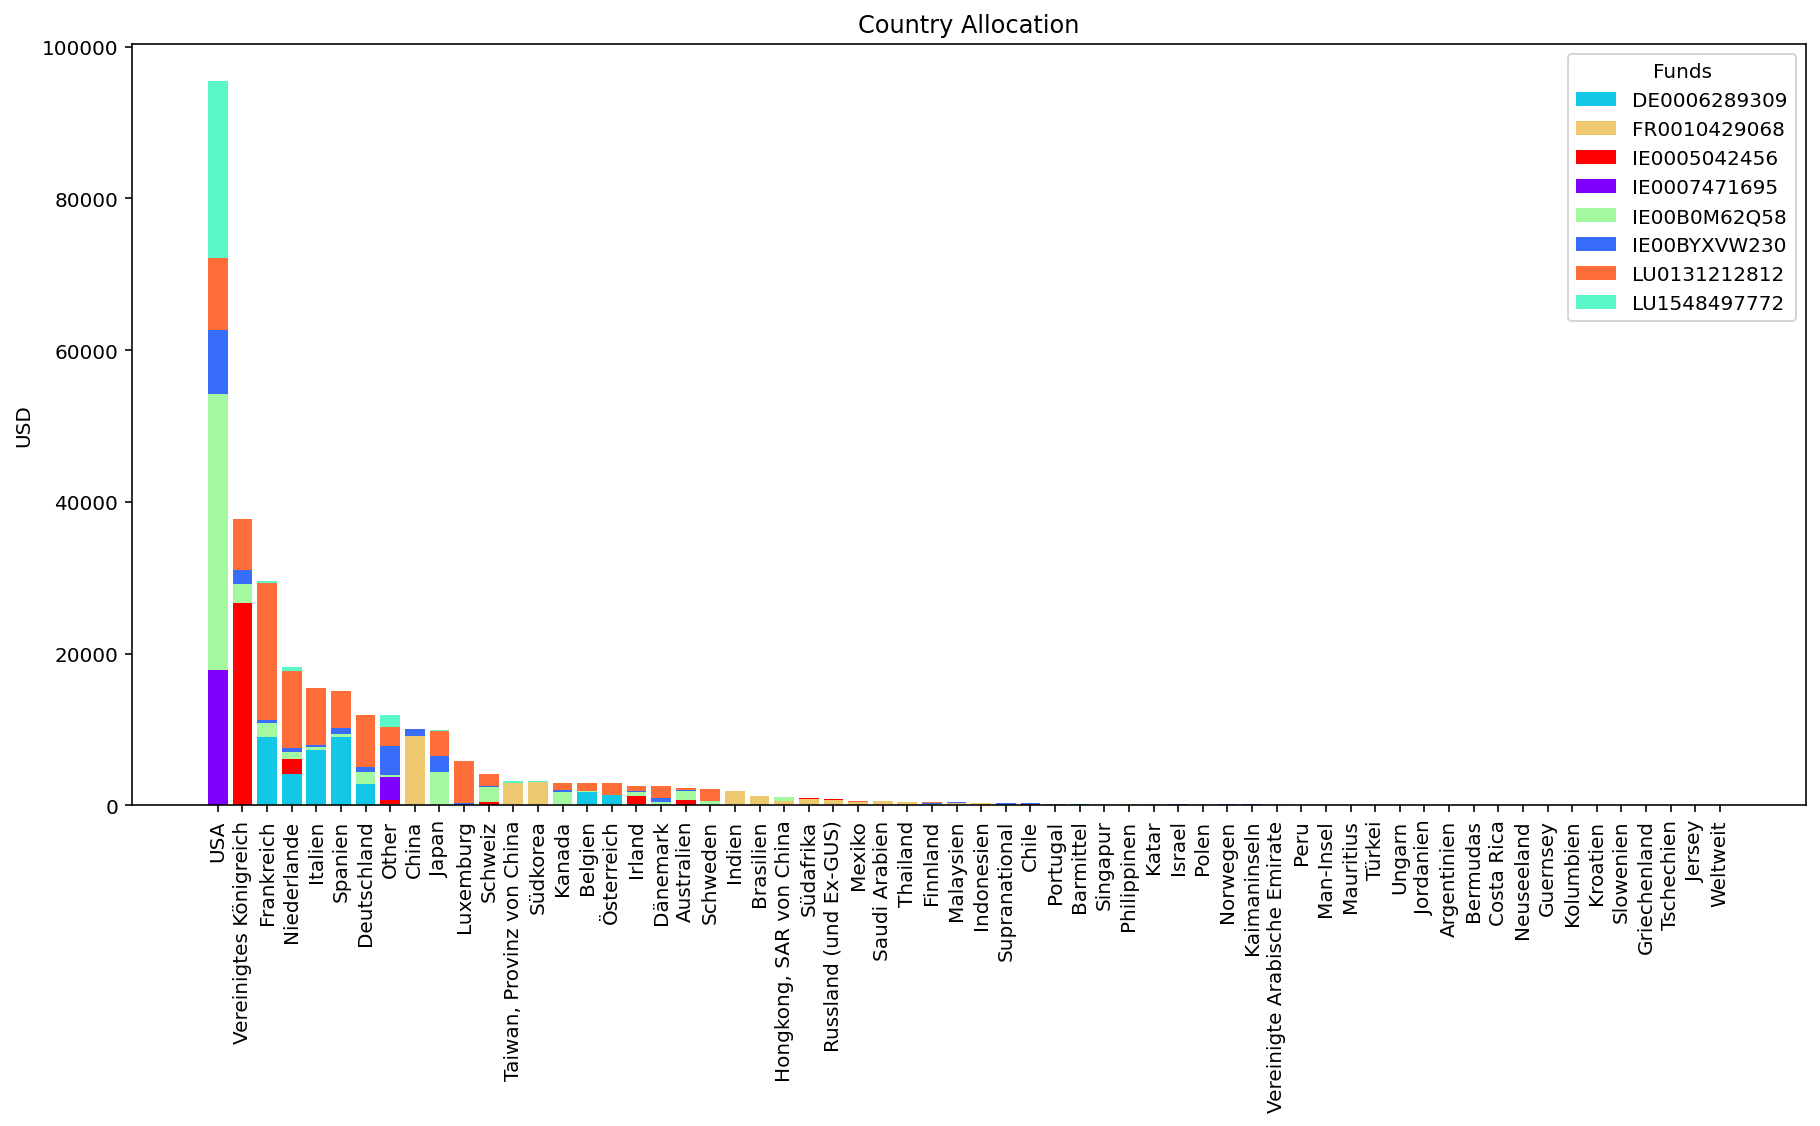

In [36]:
viz_bar(df = country, title = "Country Allocation")